Saving daily_42602_2024.csv to daily_42602_2024 (1).csv
Saving daily_42602_2023.csv to daily_42602_2023 (1).csv
Saving daily_42602_2022.csv to daily_42602_2022 (1).csv
Saving daily_42602_2021.csv to daily_42602_2021 (1).csv
Saving daily_42602_2020.csv to daily_42602_2020 (1).csv
Saving daily_42602_2019.csv to daily_42602_2019 (1).csv
Saving daily_42602_2018.csv to daily_42602_2018 (1).csv
Files found: ['daily_42602_2018 (1).csv', 'daily_42602_2020 (1).csv', 'daily_42602_2020.csv', 'daily_42602_2024.csv', 'daily_42602_2019 (1).csv', 'daily_42602_2022.csv', 'daily_42602_2022 (1).csv', 'daily_42602_2024 (1).csv', 'daily_42602_2023 (1).csv', 'daily_42602_2019.csv', 'daily_42602_2018.csv', 'daily_42602_2021.csv', 'daily_42602_2021 (1).csv', 'daily_42602_2023.csv']


/tmp/ipython-input-729252467.py:30: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
/tmp/ipython-input-729252467.py:30: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
/tmp/ipython-input-729252467.py:30: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
/tmp/ipython-input-729252467.py:30: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
/tmp/ipython-input-729252467.py:30: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f 

Dataset shape: (2196266, 29)
Columns: ['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration', 'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type', 'Observation Count', 'Observation Percent', 'Arithmetic Mean', '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name', 'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name', 'CBSA Name', 'Date of Last Change']

✅ Cleaned data preview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2196266 entries, 0 to 2196265
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   State Name   object        
 1   County Name  object        
 2   City Name    object        
 3   Date Local   datetime64[ns]
 4   NO2 Mean     float64       
 5   AQI          int64         
 6   Latitude     float64       
 7   Longitude    float64       
dtypes: datetime64[ns](1), float64(3), int64(1

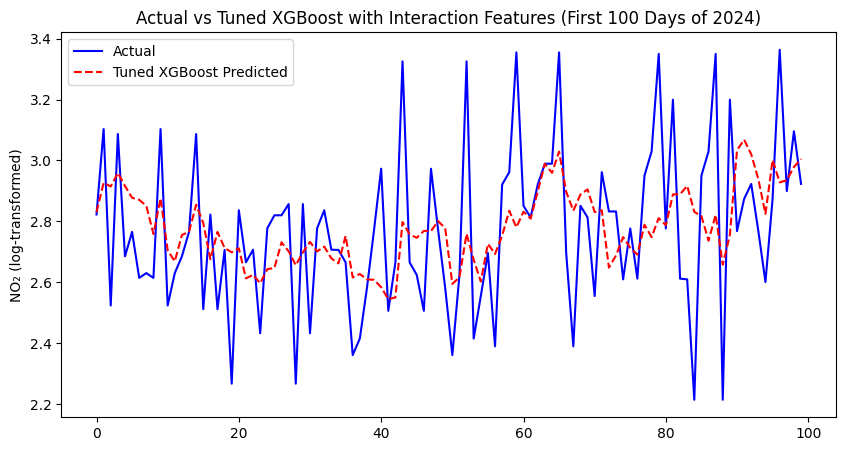

In [3]:

#import libraries
from google.colab import files
import pandas as pd
import glob
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

#upload and merge data
uploaded = files.upload()
files = glob.glob("*.csv")
print("Files found:", files)

df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

#data cleaning
df_clean = df[[
    'State Name', 'County Name', 'City Name',
    'Date Local', 'Arithmetic Mean', 'AQI',
    'Latitude', 'Longitude'
]].copy()

df_clean.rename(columns={'Arithmetic Mean': 'NO2 Mean'}, inplace=True)
df_clean['Date Local'] = pd.to_datetime(df_clean['Date Local'])
df_clean = df_clean.dropna(subset=['NO2 Mean'])

print("\n✅ Cleaned data preview:")
print(df_clean.info())

#houston only
print("\nTop 20 cities:")
print(df_clean['City Name'].value_counts().head(20))

city_df = df_clean[df_clean['City Name'] == 'Houston'].copy()
print("\nHouston dataset shape:", city_df.shape)
print("Date range:", city_df['Date Local'].min(), "to", city_df['Date Local'].max())

city_df['Month'] = city_df['Date Local'].dt.month
city_df['DayOfWeek'] = city_df['Date Local'].dt.day_name()
city_df['Year'] = city_df['Date Local'].dt.year
city_df['IsWeekend'] = city_df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

#openmeteo invocation
lat = city_df['Latitude'].iloc[0]
lon = city_df['Longitude'].iloc[0]

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": "2018-01-01",
    "end_date": "2024-12-31",
    "daily": ["temperature_2m_max","temperature_2m_min","precipitation_sum","windspeed_10m_max"],
    "timezone": "America/Chicago"
}

r = requests.get(url, params=params)
weather = pd.DataFrame(r.json()['daily'])
weather['time'] = pd.to_datetime(weather['time'])
weather.rename(columns={
    'temperature_2m_max': 'Temp_Max',
    'temperature_2m_min': 'Temp_Min',
    'precipitation_sum': 'Precipitation',
    'windspeed_10m_max': 'WindSpeed'
}, inplace=True)

merged = pd.merge(city_df, weather, left_on='Date Local', right_on='time', how='inner')
merged.drop(columns='time', inplace=True)
print("\nMerged dataset shape:", merged.shape)

#adding time series features
data = merged.sort_values('Date Local')
data['NO2_Lag1'] = data['NO2 Mean'].shift(1)
data['NO2_Lag2'] = data['NO2 Mean'].shift(2)
data['NO2_Lag7'] = data['NO2 Mean'].shift(7)
data['NO2_Rolling7'] = data['NO2 Mean'].rolling(window=7).mean()
data = data.dropna()

#feature scaling
data_scaled = data.copy()
for col in ['NO2 Mean', 'Temp_Max', 'Temp_Min', 'Precipitation', 'WindSpeed']:
    #log transformation
    data_scaled[col] = np.log1p(data_scaled[col] - data_scaled[col].min() + 1e-5)

features = ['Temp_Max', 'Temp_Min', 'Precipitation', 'WindSpeed',
            'Month', 'IsWeekend', 'NO2_Lag1', 'NO2_Lag2', 'NO2_Lag7', 'NO2_Rolling7']
target = 'NO2 Mean'

#standardize numeric features
scaler = StandardScaler()
data_scaled[features] = scaler.fit_transform(data_scaled[features])

#adding interaction and polynomial features
data_poly = data_scaled.copy()

#interaction features between weather variables
data_poly['Temp_Wind'] = data_poly['Temp_Max'] * data_poly['WindSpeed']
data_poly['Temp_Precip'] = data_poly['Temp_Min'] * data_poly['Precipitation']

#temporal and lag interactions
data_poly['Lag1_Wind'] = data_poly['NO2_Lag1'] * data_poly['WindSpeed']
data_poly['Month_Squared'] = data_poly['Month'] ** 2

#adding new columns
features = [
    'Temp_Max', 'Temp_Min', 'Precipitation', 'WindSpeed',
    'Month', 'Month_Squared', 'IsWeekend',
    'NO2_Lag1', 'NO2_Lag2', 'NO2_Lag7', 'NO2_Rolling7',
    'Temp_Wind', 'Temp_Precip', 'Lag1_Wind'
]
target = 'NO2 Mean'

train = data_poly[data_poly['Date Local'].dt.year < 2024]
test = data_poly[data_poly['Date Local'].dt.year == 2024]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

#model implementation
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\n{name} Results:\nMAE = {mae:.2f} | RMSE = {rmse:.2f} | R² = {r2:.3f}")
    return preds

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)

pred_lr = evaluate_model(lr, "Linear Regression")
pred_rf = evaluate_model(rf, "Random Forest")
pred_xgb = evaluate_model(xgb, "XGBoost")

#hp tuning XGBoost
xgb_model = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"\n✅ Tuned XGBoost with Interaction Features:\nMAE: {mae_best:.2f} | RMSE: {rmse_best:.2f} | R²: {r2_best:.3f}")

#actual vs tuned plot
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred_best[:100], label='Tuned XGBoost Predicted', color='red', linestyle='--')
plt.title('Actual vs Tuned XGBoost with Interaction Features (First 100 Days of 2024)')
plt.ylabel('NO₂ (log-transformed)')
plt.legend()
plt.show()



Approach 1:
1.	Applying log transformation to the NO2 values:
We have done this to reduce the skewness and make the NO2 data distribution more normal.
Environmental data like pollution have large spikes and these can confuse the models because they focus too much on outliers.
By taking the log of NO2 mean, we have compressed those large spikes and make the data smoother and easier for models like XGboost to learn from,
2.	Interaction features (Combined effects):
We also created new features that show how two factors might influence NO2 together.
Temp_wind = Temp_max x windspeed -> hotter, windier days may lower NO2 faster
Temp_precip =  Temp_min x precipitation -> cool, rainy days might trap or wash out pollutants.
Lag1_wind = No2_lag1 x windspeed -> links yesterday’s No2 with today’s wind dispersion.
These features help capture multi-variable relationships that single variables cannot express.
3.	Polynomial features (capturing non-linear trends)
We also added polynomial (squared) terms like month_squared to help the model identify seasonal or curved patterns ex: pollution being high in winter and low in summer, which is not a straight line relationship.
